In [94]:
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/2-ab.zip
!unzip -j 2-ab.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-ab/utils-data.py

--2022-10-20 10:03:07--  https://github.com/rdfia/rdfia.github.io/raw/master/data/2-ab.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/2-ab.zip [following]
--2022-10-20 10:03:08--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/2-ab.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13423991 (13M) [application/zip]
Saving to: ‘2-ab.zip.1’

2-ab.zip.1          100%[===================>]  12.80M  --.-KB/s    in 0.07s   

2022-10-20 10:03:09 (182 MB/s) - ‘2-ab.zip.1’ saved [13423991/13423991]

Archive:  2-ab.zip
replace ._2-ab? [y]es, [n]o

In [95]:
import math
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%run 'utils-data.py'
!pip install torchmetrics
from torchmetrics import Accuracy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Figure size 432x288 with 0 Axes>

# Part 1 : Forward and backward passes "by hands"

In [96]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}
    params["Wh"] = 0.3 * torch.randn((nh,nx))
    params["Wy"] = 0.3 * torch.randn((ny,nh))
    params["bh"] = torch.zeros((1,nh))
    params["by"] = torch.zeros((1,ny))
    return params

def forward(params, X):
    """
    params: dictionnary
    X: (n_batch, dimension)
    """
    bsize = X.size(0)
    nh = params['Wh'].size(0)
    ny = params['Wy'].size(0)
    outputs = {}

    outputs["X"] = X
    outputs["htilde"] = torch.mm(outputs["X"],torch.transpose(params['Wh'],0,1)) \
                        + params["bh"].repeat(bsize,1)
    outputs["h"] = torch.tanh(outputs["htilde"])
    outputs["ytilde"] = torch.mm(outputs["h"],torch.transpose(params['Wy'],0,1)) \
                        + params["by"].repeat(bsize,1)
    outputs["yhat"] = torch.sum(torch.exp(outputs["ytilde"]),1).resize(bsize,1) * torch.exp(outputs["ytilde"])

    return outputs['yhat'], outputs
  
def loss_accuracy(Yhat, Y):

    L = - torch.mean(torch.sum(Y * torch.log(Yhat),1))
    _,indsYhat = torch.max(Yhat,1)
    _,indsY = torch.max(Y,1)
    acc = (torch.sum(torch.eq(indsYhat,indsY))/indsY.size(0))*100 

    return L, acc

def backward(params, outputs, Y):
    bsize = Y.shape[0]
    grads = {}

    gradYtilt = outputs["yhat"] - Y
    grads["Wy"] = torch.mm(torch.transpose(gradYtilt,0,1),outputs["h"])
    gradHtilt = torch.mm(gradYtilt,params["Wy"]) * (torch.ones(outputs["h"].size()) - outputs["h"] * outputs["h"])
    grads["Wh"] = torch.mm(torch.transpose(gradHtilt,0,1),outputs["X"])
    grads["by"] = torch.sum(torch.transpose(gradYtilt,0,1),1)
    grads["bh"] = torch.sum(torch.transpose(gradHtilt,0,1),1)
    return grads

def sgd(params, grads, eta):
    """ Perform the stochastic gradient descent on the network """

    params["Wh"] = params["Wh"] - eta * grads["Wh"]  
    params["Wy"] = params["Wy"] - eta * grads["Wy"]
    params["bh"] = params["bh"] - eta * grads["bh"]
    params["by"] = params["by"] - eta * grads["by"]

    return params

## Global learning procedure "by hands"

In [ ]:
# init
N = data.Xtrain.shape[0]
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]

Nbatch = 10
N_epochs = 50
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(N_epochs):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]
        # forward pass (feeding the network of data by passing all the data across it)
        Yhat, outputs = forward(params,X)

        # compute the loss and accuracy (between prediction: Yhat result of the forward pass and Y actual value)
        loss,acc = loss_accuracy(Yhat, Y)

        # backward pass (calulate each partial derivative of the loss acccording each element of the network)
        grads = backward(params, outputs, Y)
        
        # perform gradient descent (update each bias and weight value of the network)
        params = sgd(params,grads,eta)

    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)  

    print(iteration, acctrain, Ltrain.size(), acctest, Ltest.size())
    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    data.plot_data_with_grid(Ygrid, title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

# Part 2 : Simplification of the backward pass with `torch.autograd`



In [ ]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}
    
    # activaye autograd on the network weights
    
    params["Wh"] = torch.randn((nh,nx)) 
    params["Wy"] = torch.randn((ny,nh))
    params["bh"] = torch.zeros(1,nh)
    params["by"] = torch.zeros(1,ny)
    params["Wh"].requires_grad = True
    params["Wy"].requires_grad = True
    params["bh"].requires_grad = True
    params["by"].requires_grad = True

    return params

def sgd(params, eta):
    # update the network weights
    with torch.no_grad():
      print(params['Wy'].grad,params['Wh'].grad,params['by'].grad,params['bh'].grad)
      params['Wy'] -= eta * params['Wy'].grad
      params['Wh'] -= eta * params['Wh'].grad
      params['by'] -= eta * params['by'].grad
      params['bh'] -= eta * params['bh'].grad
      params['Wy'].grad.zero_()
      params['Wh'].grad.zero_()
      params['by'].grad.zero_()    
      params['bh'].grad.zero_()      
    return params

## Global learning procedure with autograd

In [ ]:
data = CirclesData()
data.plot_data()

# init
N = data.Xtrain.shape[0]
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]

Nbatch = 5
N_epochs = 150
eta = 0.05

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        Yhat, outs = forward(params, X)
        L,_ = loss_accuracy(Yhat, Y)
        L.backward()
        params = sgd(params,eta)

    
    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)  

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    # detach() is used to remove the predictions from the computational graph in autograd
    data.plot_data_with_grid(Ygrid.detach(), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

    #break 
fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

# Part 3 : Simplification of the forward pass with `torch.nn`

`init_params` and `forward` are replaced by the `init_model` function which defines the network architecture and the loss.

In [ ]:
def init_model(nx, nh, ny):
  model = torch.nn.Sequential(
          torch.nn.Linear(nx, nh),
          torch.nn.Tanh(),
          torch.nn.Linear(nh, ny),
          torch.nn.Softmax(dim=1)
  )
  criterion = torch.nn.CrossEntropyLoss()
  return model, criterion

def loss_accuracy(criterion,predictions,labels):
  L = criterion(predictions,labels)
  _,target = torch.max(labels,1)
  accuracy = Accuracy(top_k=1)
  print(predictions.size(),target.size())
  acc = accuracy(predictions, target.int())*100
  return L,acc

def sgd(model, eta):
  with torch.no_grad():
    for param in model.parameters():
      param -= eta * param.grad
    model.zero_grad()
  return model

## Global learning procedure with autograd and `torch.nn`

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 5
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.05

model, criterion = init_model(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(100):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]
        
        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy, sgd
        # the forward with the predict method from the model
        # and the backward function with autograd

        Yhat = model(X)
        loss = criterion(Yhat, Y)
        loss.backward()
        model = sgd(model,eta)

    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(criterion, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(criterion, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)  

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title) 
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
#plt.plot(curves[2], label="loss train")
#plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Part 4 : Simplification of the SGD with `torch.optim`

In [105]:
def init_model(nx, nh, ny, eta):
    model = torch.nn.Sequential(
            torch.nn.Linear(nx, nh),
            torch.nn.Tanh(),
            torch.nn.Linear(nh, ny),
            torch.nn.Softmax(dim=1)
    )
    loss = torch.nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(),lr=eta)
    return model, loss, optim

def loss_accuracy(criterion,predictions,labels):
  L = criterion(predictions,labels)
  _,target = torch.max(labels,1)
  accuracy = Accuracy(top_k=1)
  acc = float(accuracy(predictions, target.int())*100)
  return L,acc

The `sgd` function is replaced by calling the `optim.zero_grad()` before the backward and `optim.step()` after. 

## Algorithme global d'apprentissage (avec autograd, les couches `torch.nn` et `torch.optim`)

In [106]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 5
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.05

model, criterion, optim = init_model(nx, nh, ny, eta)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        optim.zero_grad()
        
        Yhat = model(X)
        loss = criterion(Yhat, Y)
        loss.backward()
        optim.step()

    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(criterion, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(criterion, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)  

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title) 
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
# plt.plot(curves[2], label="loss train")
# plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Part 5 : MNIST

Apply the code from previous part code to the MNIST dataset.

 Finishing Epoch n° 0 , acctrain : 84.6%  , acctest : 85.4% 
 Finishing Epoch n° 1 , acctrain : 89.9%  , acctest : 90.2% 
 Finishing Epoch n° 2 , acctrain : 90.6%  , acctest : 90.5% 
 Finishing Epoch n° 3 , acctrain : 91.3%  , acctest : 91.9% 
 Finishing Epoch n° 4 , acctrain : 91.9%  , acctest : 92.1% 
 Finishing Epoch n° 5 , acctrain : 92.1%  , acctest : 91.9% 
 Finishing Epoch n° 6 , acctrain : 92.1%  , acctest : 92.0% 
 Finishing Epoch n° 7 , acctrain : 92.3%  , acctest : 92.5% 
 Finishing Epoch n° 8 , acctrain : 92.3%  , acctest : 92.6% 
 Finishing Epoch n° 9 , acctrain : 92.1%  , acctest : 92.0% 
 Finishing Epoch n° 10 , acctrain : 92.3%  , acctest : 92.2% 
 Finishing Epoch n° 11 , acctrain : 92.5%  , acctest : 92.4% 
 Finishing Epoch n° 12 , acctrain : 92.5%  , acctest : 92.0% 
 Finishing Epoch n° 13 , acctrain : 92.8%  , acctest : 92.8% 
 Finishing Epoch n° 14 , acctrain : 92.7%  , acctest : 92.8% 
 Finishing Epoch n° 15 , acctrain : 93.1%  , acctest : 92.8% 
 Finishing Epoch n

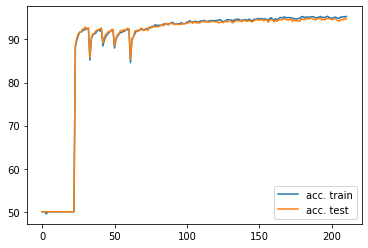

In [ ]:
# init
data = MNISTData()
N = data.Xtrain.shape[0]
Nbatch = 100
nx = data.Xtrain.shape[1]
nh = 100
ny = data.Ytrain.shape[1]
eta = 0.03
N_epochs = 150

model, criterion, optim = init_model(nx, nh, ny, eta)

for epoch in range(N_epochs):
    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        optim.zero_grad()
        
        Yhat = model(X)
        loss = criterion(Yhat, Y)
        loss.backward()
        optim.step()

    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(criterion, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(criterion, Yhat_test, data.Ytest)
    print(" Finishing Epoch n° {} , acctrain : {:.1f}%  , acctest : {:.1f}% ".format(str(epoch),acctrain,acctest))

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
# plt.plot(curves[2], label="loss train")
# plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

# Part 6: Bonus: SVM


Train a SVM model on the Circles dataset.

Ideas : 
- First try a linear SVM (sklearn.svm.LinearSVC dans scikit-learn). Does it work well ? Why ?
- Then try more complex kernels (sklearn.svm.SVC). Which one is the best ? why ?
- Does the parameter C of regularization have an impact? Why ?

In [ ]:
# data
data = CirclesData()
Xtrain = data.Xtrain.numpy()
Ytrain = data.Ytrain[:, 0].numpy()

Xgrid = data.Xgrid.numpy()

Xtest = data.Xtest.numpy()
Ytest = data.Ytest[:, 0].numpy()

def plot_svm_predictions(data, predictions):
      plt.figure(2)
      plt.clf()
      plt.imshow(np.reshape(predictions, (40,40)))
      plt.plot(data._Xtrain[data._Ytrain[:,0] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,0] == 1,1]*10+20, 'bo', label="Train")
      plt.plot(data._Xtrain[data._Ytrain[:,1] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,1] == 1,1]*10+20, 'ro')
      plt.plot(data._Xtest[data._Ytest[:,0] == 1,0]*10+20, data._Xtest[data._Ytest[:,0] == 1,1]*10+20, 'b+', label="Test")
      plt.plot(data._Xtest[data._Ytest[:,1] == 1,0]*10+20, data._Xtest[data._Ytest[:,1] == 1,1]*10+20, 'r+')
      plt.xlim(0,39)
      plt.ylim(0,39)
      plt.clim(0.3,0.7)
      plt.draw()
      plt.pause(1e-3)

In [ ]:
import sklearn.svm

############################
### Your code here   #######
### Train the SVM    #######
## See https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
## and https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
############################

svm = None

###########################

In [ ]:
## Print results

Ytest_pred = svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred)